In [1]:
# Import Libraries

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
# List all available devices
devices = tf.config.list_physical_devices()
for device in devices:
    device_details = tf.config.experimental.get_device_details(device)
    print(f"Device: {device.name}, Type: {device.device_type}, Details: {device_details}")

Device: /physical_device:CPU:0, Type: CPU, Details: {}
Device: /physical_device:GPU:0, Type: GPU, Details: {'device_name': 'NVIDIA GeForce GTX 1650', 'compute_capability': (7, 5)}


In [3]:
batch_size = 64 # as per paper said (128)

# Define data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

# Get the current working directory
current_directory = os.getcwd()

# Load and augment the dataset
dataset_dir = os.path.join(current_directory, "Caltech_256/256_ObjectCategories")


train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(227, 227),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(227, 227),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Print the number of images in training and validation sets
print("=====")
print("# Dataset Summary")
print("-----")
print(f"Training set: {train_generator.samples} images, {train_generator.num_classes} classes")
print(f"Validation set: {validation_generator.samples} images, {validation_generator.num_classes} classes")
print("-----")

# Optionally, print class names for reference
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

Found 26132 images belonging to 257 classes.
Found 4475 images belonging to 257 classes.
=====
# Dataset Summary
-----
Training set: 26132 images, 257 classes
Validation set: 4475 images, 257 classes
-----
Classes: ['airplanes-101', 'ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-side-101', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'clutter', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'd

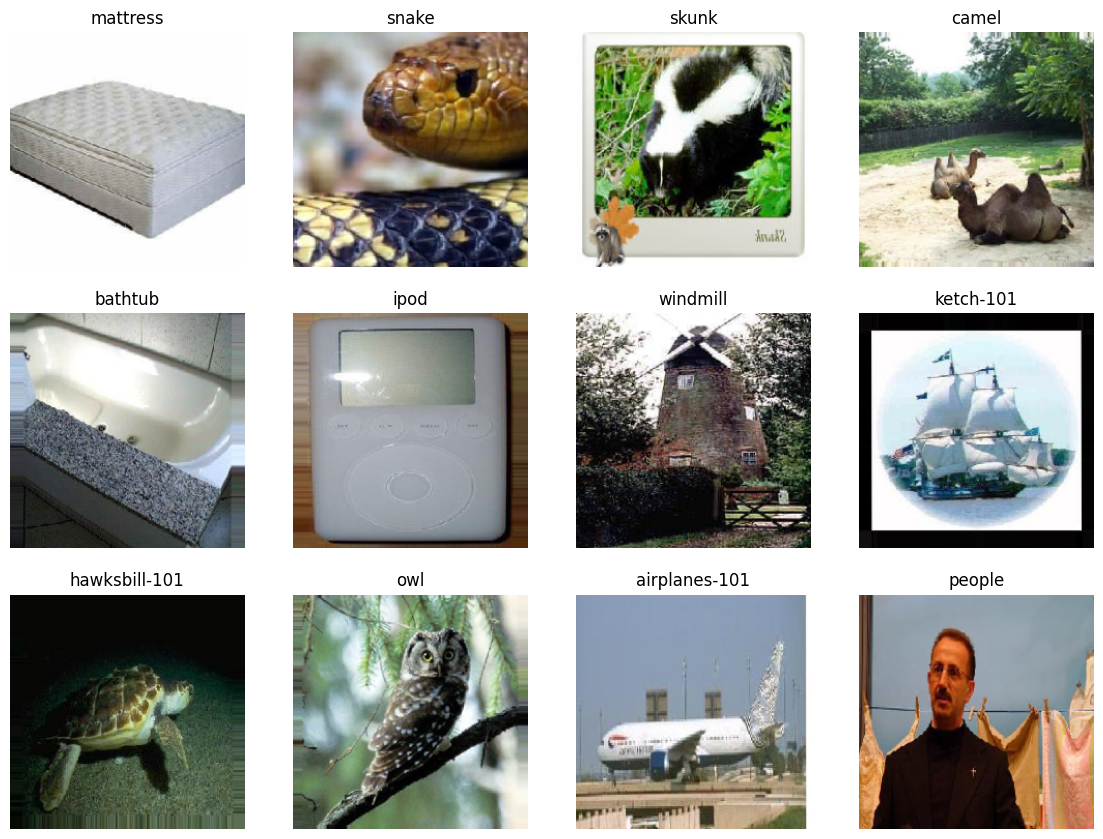

In [4]:
# Function to plot images
def plot_images_from_generator(generator, num_images=12):
    # Retrieve a batch of images and labels
    images, labels = next(generator)
    
    # Define the class names
    class_names = list(generator.class_indices.keys())
    
    # Plot the images
    plt.figure(figsize=(14, 14))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
    
    plt.show()

# Plot 12 random images from the training generator
plot_images_from_generator(train_generator, num_images=12)

---

### **AlexNet Architecture**

The following table provides a detailed breakdown of the AlexNet architecture, including the size of each operation, the filters used, depth, stride, padding, the number of parameters, weight matrix shape, bias size, number of neurons, and the forward computation:

| **Layer**                        | **Output Shape (H,W,C)** | **Filter Size (H,W)** | **Depth (C)** | **Stride (s)** | **Padding (p)** | **Weight Matrix Shape**   | **No. of Bias** | **No. of Learnable Neurons** | **No. of Parameters**               | **No. of Computations (Forward Pass)**           |
|----------------------------------|--------------------------|-----------------------|---------------|----------------|-----------------|---------------------------|-----------------|-----------------------------|--------------------------------------|---------------------------------------------------|
| **Input Layer**                  | 227x227x3                 | -                     | 3             | -              | -               | -                         | -               | 227x227x3 = 154,587          | -                                    | -                                                 |
| **Conv 1 (Layer_1)**             | 55x55x96                  | 11x11                 | 96            | 4              | 0               | (11x11x3, 96)             | 96              | 55x55x96 = 290,400           | (11x11x3)x96 + 96 = **34,944**       | 55x55x96x(11x11x3) = **105,415,680**              |
| **Local Response Norm 1 (Layer_1)**| 55x55x96                  | -                     | 96            | -              | -               | -                         | -               | -                           | -                                    | -                                                 |
| **Max Pooling 1 (Layer_1)**      | 27x27x96                  | 3x3                   | 96            | 2              | 0               | -                         | -               | -                           | -                                    | -                                                 |
| **Conv 2 (Layer_2)**             | 27x27x256                 | 5x5                   | 256           | 1              | 2               | (5x5x96, 256)             | 256             | 27x27x256 = 186,624          | (5x5x96)x256 + 256 = **614,656**     | 27x27x256x(5x5x96) = **83,869,440**               |
| **Local Response Norm 2 (Layer_2)**| 27x27x256                 | -                     | 256           | -              | -               | -                         | -               | -                           | -                                    | -                                                 |
| **Max Pooling 2 (Layer_2)**      | 13x13x256                 | 3x3                   | 256           | 2              | 0               | -                         | -               | -                           | -                                    | -                                                 |
| **Conv 3 (Layer_3)**             | 13x13x384                 | 3x3                   | 384           | 1              | 1               | (3x3x256, 384)            | 384             | 13x13x384 = 64,896           | (3x3x256)x384 + 384 = **884,736**    | 13x13x384x(3x3x256) = **11,776,512**              |
| **Conv 4 (Layer_4)**             | 13x13x384                 | 3x3                   | 384           | 1              | 1               | (3x3x384, 384)            | 384             | 13x13x384 = 64,896           | (3x3x384)x384 + 384 = **1,327,104**  | 13x13x384x(3x3x384) = **17,664,000**              |
| **Conv 5 (Layer_5)**             | 13x13x256                 | 3x3                   | 256           | 1              | 1               | (3x3x384, 256)            | 256             | 13x13x256 = 43,264           | (3x3x384)x256 + 256 = **884,736**    | 13x13x256x(3x3x384) = **11,776,512**              |
| **Max Pooling 3 (Layer_5)**      | 6x6x256                   | 3x3                   | 256           | 2              | 0               | -                         | -               | -                           | -                                    | -                                                 |
| **Fully Connected 1 (Layer_6)**  | 1x1x4096                  | -                     | 4096          | -              | -               | (6x6x256, 4096)           | 4096            | 4096                        | (6x6x256)x4096 + 4096 = **37,752,832** | 4096x(6x6x256) = **37,752,832**                   |
| **Fully Connected 2 (Layer_7)**  | 1x1x4096                  | -                     | 4096          | -              | -               | (4096, 4096)              | 4096            | 4096                        | 4096x4096 + 4096 = **16,781,312**    | 4096x4096 = **16,777,216**                        |
| **Fully Connected 3 (Output)**   | 1x1x1000                  | -                     | 1000          | -              | -               | (4096, 1000)              | 1000            | 1000                        | 4096x1000 + 1000 = **4,097,000**      | 4096x1000 = **4,096,000**                          |

---


In [5]:
# Define the custom LocalResponseNormalization layer
class LocalResponseNormalization(layers.Layer):
    def __init__(self, depth_radius, bias, alpha, beta, name, **kwargs):
        super(LocalResponseNormalization, self).__init__(name=name, **kwargs)
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta

    def call(self, inputs):
        return tf.nn.local_response_normalization(
            inputs,
            depth_radius=self.depth_radius,
            bias=self.bias,
            alpha=self.alpha,
            beta=self.beta,
            name=self.name
        )

# Define the AlexNet model as a subclass of the Model class
class AlexNet(Model):
    def __init__(self, input_shape=(227, 227, 3), num_classes=1000, name="AlexNet"):
        super(AlexNet, self).__init__(name=name)

        # [Layer1] First convolutional layer 
        self.conv1 = layers.Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu', name='conv_layer1')
        self.lrn1 = LocalResponseNormalization(depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75, name='local_response_norm_layer1')
        self.pool1 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='max_pool_layer1')
        
        # [Layer2] Second convolutional layer
        self.conv2 = layers.Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu', name='conv_layer2')
        self.lrn2 = LocalResponseNormalization(depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75, name='local_response_norm_layer2')
        self.pool2 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='max_pool_layer2')
        
        # [Layer3] Third convolutional layer
        self.conv3 = layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='conv_layer3')
        
        # [Layer4] Fourth convolutional layer
        self.conv4 = layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu', name='conv_layer4')
        
        # [Layer5] Fifth convolutional layer
        self.conv5 = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv_layer5')
        self.pool3 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='max_pool_layer5')
        
        # Flatten the tensor to prepare for the fully connected layers
        self.flatten = layers.Flatten()

        # [Layer6] First fully-connected layer with dropout
        self.fc1 = layers.Dense(units=4096, activation='relu', name='dense_layer6')
        self.dropout1 = layers.Dropout(rate=0.5, name='dropout_layer6')

        # [Layer7] Second fully-connected layer with dropout
        self.fc2 = layers.Dense(units=4096, activation='relu', name='dense_layer7')
        self.dropout2 = layers.Dropout(rate=0.5, name='dropout_layer7')

        # [Layer8] Third fully-connected layer / Output layer with softmax activation
        self.fc3 = layers.Dense(units=num_classes, activation='softmax', name='dense_output_layer8')

    # Define the forward pass
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.lrn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.lrn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        
        x = self.conv4(x)
        
        x = self.conv5(x)
        x = self.pool3(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.dropout2(x)
        
        return self.fc3(x)

    # Build the graph for the model with a given input shape
    def build_graph(self, input_shape=(227, 227, 3)):
        input_x = Input(shape=input_shape, name='input_layer')
        return Model(inputs=input_x, outputs=self.call(input_x), name=self.name)


In [6]:
# Instantiate the model
alexnet_model = AlexNet(input_shape=(227, 227, 3), num_classes=1000)

# Build the graph for the model
alexnet_graph = alexnet_model.build_graph()

# Print the model summary
alexnet_graph.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 227, 227, 3)]     0         
                                                                 
 conv_layer1 (Conv2D)        (None, 55, 55, 96)        34944     
                                                                 
 local_response_norm_layer1   (None, 55, 55, 96)       0         
 (LocalResponseNormalization                                     
 )                                                               
                                                                 
 max_pool_layer1 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv_layer2 (Conv2D)        (None, 27, 27, 256)       614656    
                                                           

In [7]:
# Model Parameters:
input_shape = (227, 227, 3)
num_classes = len(train_generator.class_indices)
batch_size = 64 # as per paper said (128)
epochs = 45  # as per paper said (90)

# Initialize the model
model = AlexNet(input_shape=input_shape, num_classes=num_classes)
        
# Compile the model with SGD optimizer
sgd_optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    decay=0.0005,
    nesterov=False
)

# Define top-1 and top-5 accuracy metrics
top1_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top1_accuracy')
top5_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_accuracy')

# Model Complining:
model.compile(optimizer=sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', top1_acc, top5_acc])

# # Define EarlyStopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define ReduceLROnPlateau to adjust learning rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation loss
    factor=0.1,          # Reduce learning rate by a factor of 10
    patience=5,          # Number of epochs to wait before reducing the learning rate
    verbose=1,            # Print messages when the learning rate is adjusted
    min_lr=1e-5
)


# Measure training time
training_start_time = time.time()

# Use GPU if available, else fall back to CPU
if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        # Train the model
        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=epochs,
                            callbacks=[lr_scheduler]
                           )
else:
    with tf.device('/CPU:0'):
        # Train the model
        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            epochs=epochs,
                            callbacks=[lr_scheduler]
                           )

training_end_time = time.time()
training_time = (training_end_time - training_start_time) / 60

# Print the model summary
model.build_graph()
print(model.summary())
print(f"Training time: {training_time:.2f} mins")

Epoch 1/45
409/409 [==============================] - 509s 1s/step - loss: 5.4505 - accuracy: 0.0257 - top1_accuracy: 0.0257 - top5_accuracy: 0.1000 - val_loss: 5.4086 - val_accuracy: 0.0268 - val_top1_accuracy: 0.0268 - val_top5_accuracy: 0.1075 - lr: 0.0100
Epoch 2/45
409/409 [==============================] - 277s 676ms/step - loss: 5.4106 - accuracy: 0.0342 - top1_accuracy: 0.0342 - top5_accuracy: 0.1042 - val_loss: 5.3364 - val_accuracy: 0.0358 - val_top1_accuracy: 0.0358 - val_top5_accuracy: 0.1073 - lr: 0.0100
Epoch 3/45
409/409 [==============================] - 280s 685ms/step - loss: 5.2316 - accuracy: 0.0671 - top1_accuracy: 0.0671 - top5_accuracy: 0.1265 - val_loss: 5.0293 - val_accuracy: 0.0746 - val_top1_accuracy: 0.0746 - val_top5_accuracy: 0.1636 - lr: 0.0100
Epoch 4/45
409/409 [==============================] - 282s 689ms/step - loss: 4.9573 - accuracy: 0.0930 - top1_accuracy: 0.0930 - top5_accuracy: 0.1747 - val_loss: 4.7443 - val_accuracy: 0.1001 - val_top1_accuracy:

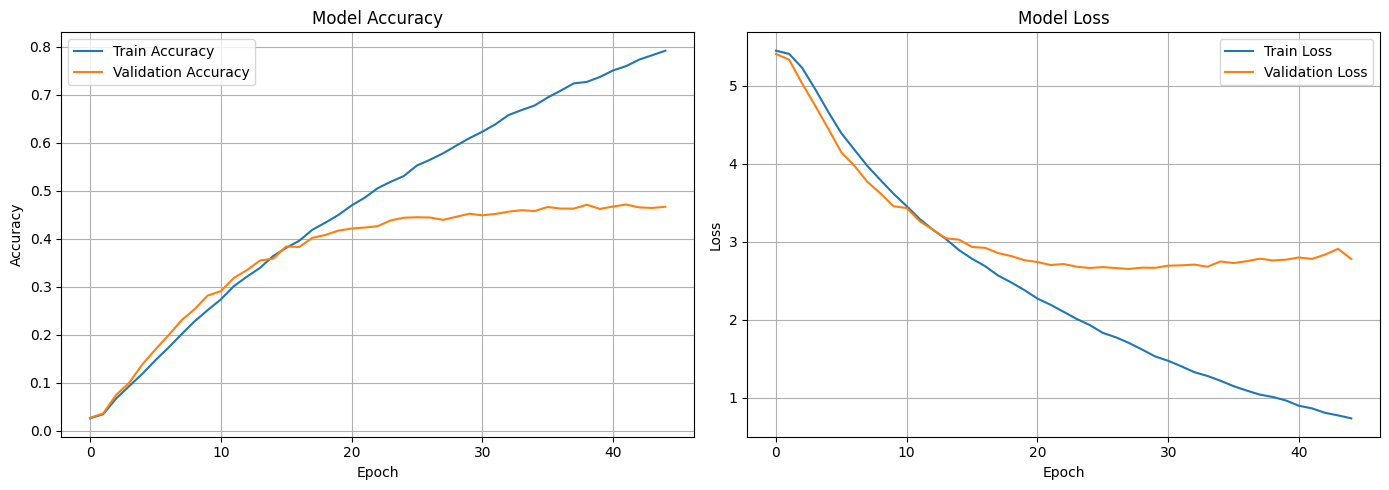

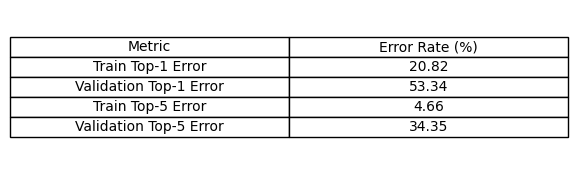

In [8]:
# Method to plot training and validation metrics
def plot_metrics(history):
    # Create subplots for accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Compute error rates for the final epoch
    final_epoch = len(history.history['accuracy']) - 1
    train_top1_error = (1 - history.history['top1_accuracy'][final_epoch]) * 100
    val_top1_error = (1 - history.history['val_top1_accuracy'][final_epoch]) * 100
    train_top5_error = (1 - history.history['top5_accuracy'][final_epoch]) * 100
    val_top5_error = (1 - history.history['val_top5_accuracy'][final_epoch]) * 100

    # Create a table to display the error rates for the final epoch in percentage
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')
    table_data = [
        ["Metric", "Error Rate (%)"],
        ["Train Top-1 Error", f"{train_top1_error:.2f}"],
        ["Validation Top-1 Error", f"{val_top1_error:.2f}"],
        ["Train Top-5 Error", f"{train_top5_error:.2f}"],
        ["Validation Top-5 Error", f"{val_top5_error:.2f}"]
    ]

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.show()

# Plot the accuracy, loss curves, and error rate table
plot_metrics(history)

In [9]:
# Preprocess the image to the required size and scale
def preprocess_image(img_path, target_size=(227, 227)):
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img


# Decode the predictions to get top-1 and top-5 categories with probabilities
def decode_predictions(preds, class_indices, top=5):

    # Map class indices to class names and sort predictions
    index_to_class = {v: k for k, v in class_indices.items()}
    top_indices = preds[0].argsort()[-top:][::-1]
    top_classes = [index_to_class[i] for i in top_indices]
    top_probs = preds[0, top_indices]
    return top_classes, top_probs


# Predict and display the top-1 and top-5 categories with probabilities for the given image.
def predict_and_display(img_path, model, class_indices):

    # Preprocess the image
    img_array, img = preprocess_image(img_path)

    # Make predictions
    preds = model.predict(img_array)

    # Decode predictions
    top_classes, top_probs = decode_predictions(preds, class_indices, top=5)

    # Display the image
    plt.imshow(img)
    plt.axis('off')

    # Display top-1 prediction
    top_1_class = top_classes[0]
    top_1_prob = top_probs[0]
    plt.title(f"{top_1_class} ({top_1_prob*100:.2f}%)", fontsize=14, color='blue')

    plt.show()

    # Display top-5 predictions
    print("Top-5 Predictions:")
    for i, (cls, prob) in enumerate(zip(top_classes, top_probs)):
        print(f"{i + 1}. {cls} ({prob*100:.2f}%)")


1/1 [==============================] - 1s 744ms/step


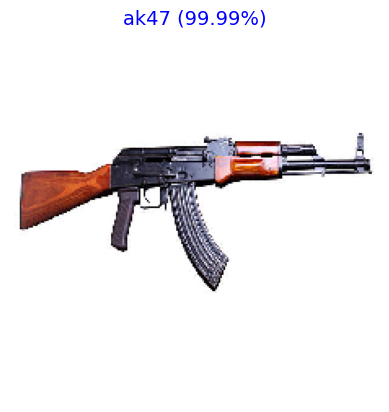

Top-5 Predictions:
1. ak47 (99.99%)
2. umbrella-101 (0.01%)
3. rifle (0.00%)
4. eyeglasses (0.00%)
5. picnic-table (0.00%)


In [10]:
# Example usage
image_path = 'images/ak47.jpg'
predict_and_display(image_path, model, train_generator.class_indices)

1/1 [==============================] - 0s 29ms/step


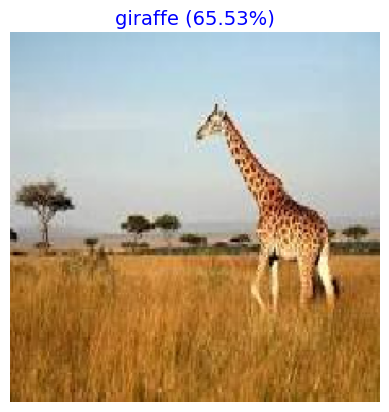

Top-5 Predictions:
1. giraffe (65.53%)
2. teepee (20.88%)
3. pyramid (5.60%)
4. windmill (2.60%)
5. horse (0.83%)


In [11]:
# Example usage
image_path = 'images/giraffe.jpeg'
predict_and_display(image_path, model, train_generator.class_indices)

In [12]:
# Save the model weights to a file
weights_save_file = 'caltech256_alexnet_weights.h5'
model.save_weights(weights_save_file)
print(f"Model weights saved to {weights_save_file}")

Model weights saved to caltech256_alexnet_weights.h5


In [13]:
# After saving weights, you can reload the model weights later for predictions

# Initialize the model (use the same architecture)
loaded_model = AlexNet(input_shape=input_shape, num_classes=num_classes)

# Initialize the model to create weights (dummy forward pass)
dummy_input = np.random.random((1, *input_shape))  # Create a dummy input
loaded_model(dummy_input)  # Call the model to initialize weights

# Load the weights into the model
loaded_model.load_weights('caltech256_alexnet_weights.h5')
print(f"Model weights loaded from {'caltech256_alexnet_weights.h5'}")

Model weights loaded from caltech256_alexnet_weights.h5


1/1 [==============================] - 0s 23ms/step


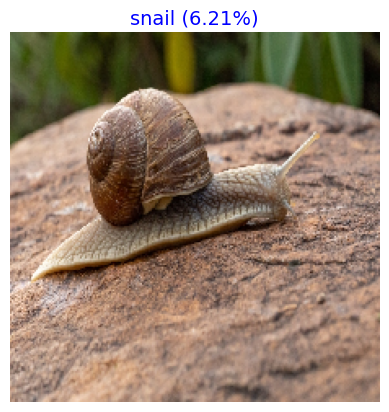

Top-5 Predictions:
1. snail (6.21%)
2. trilobite-101 (4.71%)
3. coin (3.67%)
4. centipede (3.48%)
5. rifle (3.44%)


In [14]:
# Example usage
image_path = 'images/snail.jpg'
predict_and_display(image_path, model, train_generator.class_indices)

1/1 [==============================] - 0s 29ms/step


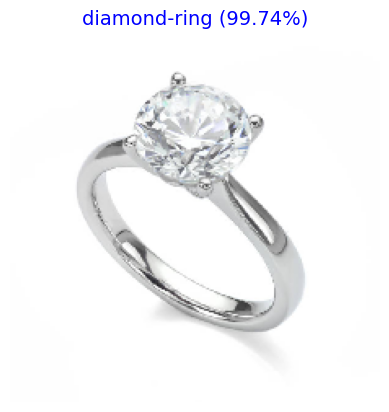

Top-5 Predictions:
1. diamond-ring (99.74%)
2. paperclip (0.12%)
3. syringe (0.04%)
4. computer-mouse (0.02%)
5. ipod (0.02%)


In [15]:
# Example usage
image_path = 'images/diamond-ring.jpg'
predict_and_display(image_path, model, train_generator.class_indices)

1/1 [==============================] - 0s 31ms/step


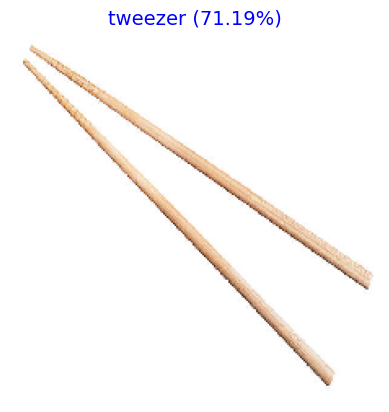

Top-5 Predictions:
1. tweezer (71.19%)
2. chopsticks (26.48%)
3. baseball-bat (1.04%)
4. drinking-straw (0.46%)
5. tuning-fork (0.33%)


In [16]:
# Example usage
image_path = 'images/chopsticks.jpg'
predict_and_display(image_path, model, train_generator.class_indices)